# Exercicio TP - Módulo de Computação Quântica
## Interação e Concorrência 2023/2024 - LCC
### Realizado por Bruno Miguel Fernandes Araújo nº 97509

In [1]:
from qiskit import *
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import ZGate, MCXGate
import numpy as np

def execute_circuit(qc, shots=1024, binary=False, mode="sampler", reverse=False):
    
    if reverse:
        qc = qc.reverse_bits()
        
    if mode == "sampler":
    
        options = {"shots": shots}

        sampler = Sampler(options=options)
        
        job = sampler.run(qc)
        result = job.result()  
        
        probability_dictionary = result.quasi_dists[0]

        if binary:
            return probability_dictionary.binary_probabilities()
        else:
            return probability_dictionary
    
    else:
        #remember that for statevector measurements are not needed
        sv = Statevector.from_instruction(qc)
        return sv


## Exercício 1

Considerando a função boleana **f** representada nesta questão, o oráculo descrito em baixo denota o comportamento pretendido da função.
Considere a seguinte função booleana $f:\{0,1\} \rightarrow \{0,1\}$:

<p align="center">
  <img width="300" height="300" src="images/enunciadoexc1.png">
</p>

Identifique o tipo de função booleana e implemente o algoritmo de Deutsch para identificar
corretamente a função. Comente sobre os resultados esperados e obtidos.

### Resposta:
Podemos ver pelo enunciado que esta função booleana terá de ser balanceada, pois metade dos elementos dão output **1** e  a outra metade dá output **2**, logo será esperado que o algoritmo Deutsch,  neste caso o Deutsch-Josza pois estamos a trabalhar com mais que 1 qubit, dê balanceada.

Começamos então por definir a função Deutsch-Josza:

In [2]:
#deutsch mas para mais que um qubit
def deutsch_jozsa(U_f=None, n_qubits=3):

    cr = ClassicalRegister(n_qubits,"measure")
    qr_input = QuantumRegister(n_qubits,"input")
    qr_ancilla = QuantumRegister(1,"ancilla") # qubit que representa o output
    qc = QuantumCircuit(qr_input,qr_ancilla,cr)

    

    # qubits input
    #for i in range(n_qubits):
    qc.h(qr_input)
        
    #ancilla
    qc.x(qr_ancilla) # bit-flip para a ancila começar em 1
    qc.h(qr_ancilla)
    
    qc.barrier()
    
    #compose circuit with U_f
    qc = qc.compose(U_f)
    
    qc.barrier()
    
    #interference input qubits
    #for i in range(n_qubits):
    qc.h(qr_input)
        
    #measure the input qubits 
    qc.measure(qr_input,cr)
    return qc

Temos presente 3 qubits logo n_qubits será igual a 3.
O racíciono por detrás deste foi o mesmo que foi usado nas aulas práticas:
Usei hadamar nos 3 qubits de input.


Bit-flip (gate not) da ancilla pois queremos que este qubit que representa o output, comece a 1.

Hadamar na ancilla.

E por fim depois da composição de U_f , temos hadamar nos 3 qubits de input seguido da medição destes.

Agora falta definir U_f , que defini da seguinte forma:

In [3]:
def U_f(n_qubits = 3,caso = "ancilla 1"):
    qr_input = QuantumRegister(n_qubits, "input")# qubits input
    qr_ancilla = QuantumRegister(1, "ancilla")# o é o número de qubits que representam a ancilla

    qc = QuantumCircuit(qr_input,qr_ancilla)
    if caso=="ancilla 1":
        qc.cx(qr_input[-1],qr_ancilla)
    if caso=="ancilla 0":
        qc.x(qr_input[-1])# se for 0 passa a 1 e ativa o cx se for 1 passa a 0dd
        qc.cx(qr_input[-1],qr_ancilla)# ultimo bit é o de controlo 
        qc.x(qr_input[-1])# voltar ao estado original
    
    return qc

Podemos ver pela tabela do enunciado, que o bit que afetará o output será o ultimo (o mais á esquerda), se este for 0 o output(ancilla) será 1 e se este for 1 o output será 0, podemos associar este comportamento logo ao gate CNOT.

Logo basta fazer o cx pois já sabemos que a ancilla, no momento que usamos o U_f, encontra-se a 1.

Se não tivessemos a ancilla a 1 , teriamos de fazer o gate pauli seguido de um gate cnot e de, novamente, um gate pauli.

Isto pois assim se o bit de controlo for 0 a ancilla vai ser 0 e se este for 1 a ancilla vai ser 1. 

E no fim teriamos de fazer um gate de pauli pois temos de colocar este bit de controlo no seu estado original.

Como o algoritmo de Deutsch-Josza coloca a ancilla a 1 logo no inicio, temos de entrar no if com o caso "ancilla 1".

Temos então a seguinte representação do U_f em circuito:

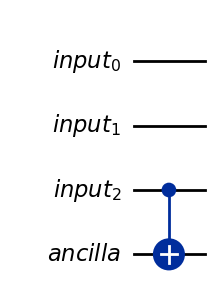

In [4]:
u_f = U_f()
qc = u_f
qc.draw(output="mpl")

Aplicando então deutsch ao U_f definido, obtemos o seguinte circuito:

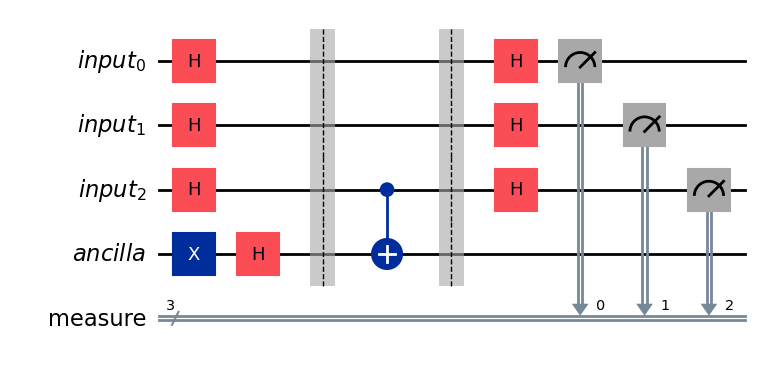

In [5]:
u_f = U_f(3,"ancilla 1")
qc = deutsch_jozsa(U_f=u_f)
qc.draw(output="mpl")

E após a execução deste, obtemos o seguinte grafico de probabilidade:

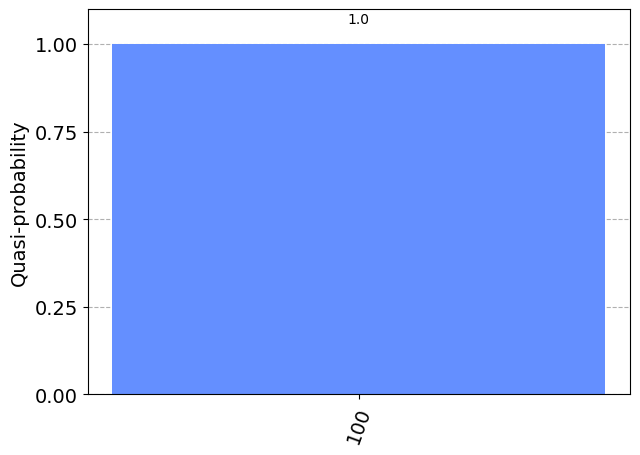

In [6]:
probs = execute_circuit(qc,shots=1000,binary=True,mode="sampler")
plot_histogram(probs)

Através deste , concluimos que ,usando o algoritmo de deutsch, a função em questão é balanceada, pois a medição do estado deu uma probabilidade de 1!

## Exercicio 2:
Considere uma base de dados com um total de N=16 elementos.


### a) 
Implemente o algoritmo de Grover para encontrar o elemento indexado pelo estado **|0010⟩**. Indique o número ótimo de iterações de Grover e a probabilidade expectável de medir o elemento. Comente sobre os resultados experimentais obtidos.

## Resposta

Usando a seguinte definição dada nas aulas:

In [7]:
def oracle(qr, ancilla, solution=None):
    
    qc = QuantumCircuit(qr,ancilla)
    cx_gate = MCXGate(len(qr),ctrl_state=solution)
    qc = qc.compose(cx_gate)
    
    qc.barrier()
    return qc

def diffusion_operator(qr, ancilla, n_qubits=4):

    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr[-1])
    cz = ZGate().control(n_qubits-1,ctrl_state="0"*(n_qubits-1))
    qc = qc.compose(cz)
    qc.x(qr[-1])

    qc.h(qr)

    qc.barrier()
    
    return qc 


#Estado inicial
qr=QuantumRegister(4,"DB")
ancilla=QuantumRegister(1,"ancilla")
cr=ClassicalRegister(4)
qc =QuantumCircuit(qr,ancilla,cr)
elements = 16 # N , 2^4

qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)

qc.barrier()

solution = "0010"
iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

# Grover j - vezes

for j in range(iterations):
    qc = qc.compose(oracle(qr,ancilla,solution=solution))
    qc = qc.compose(diffusion_operator(qr,ancilla,4))

qc.measure(qr,cr)
print()

O circuito fica da seguinte forma:

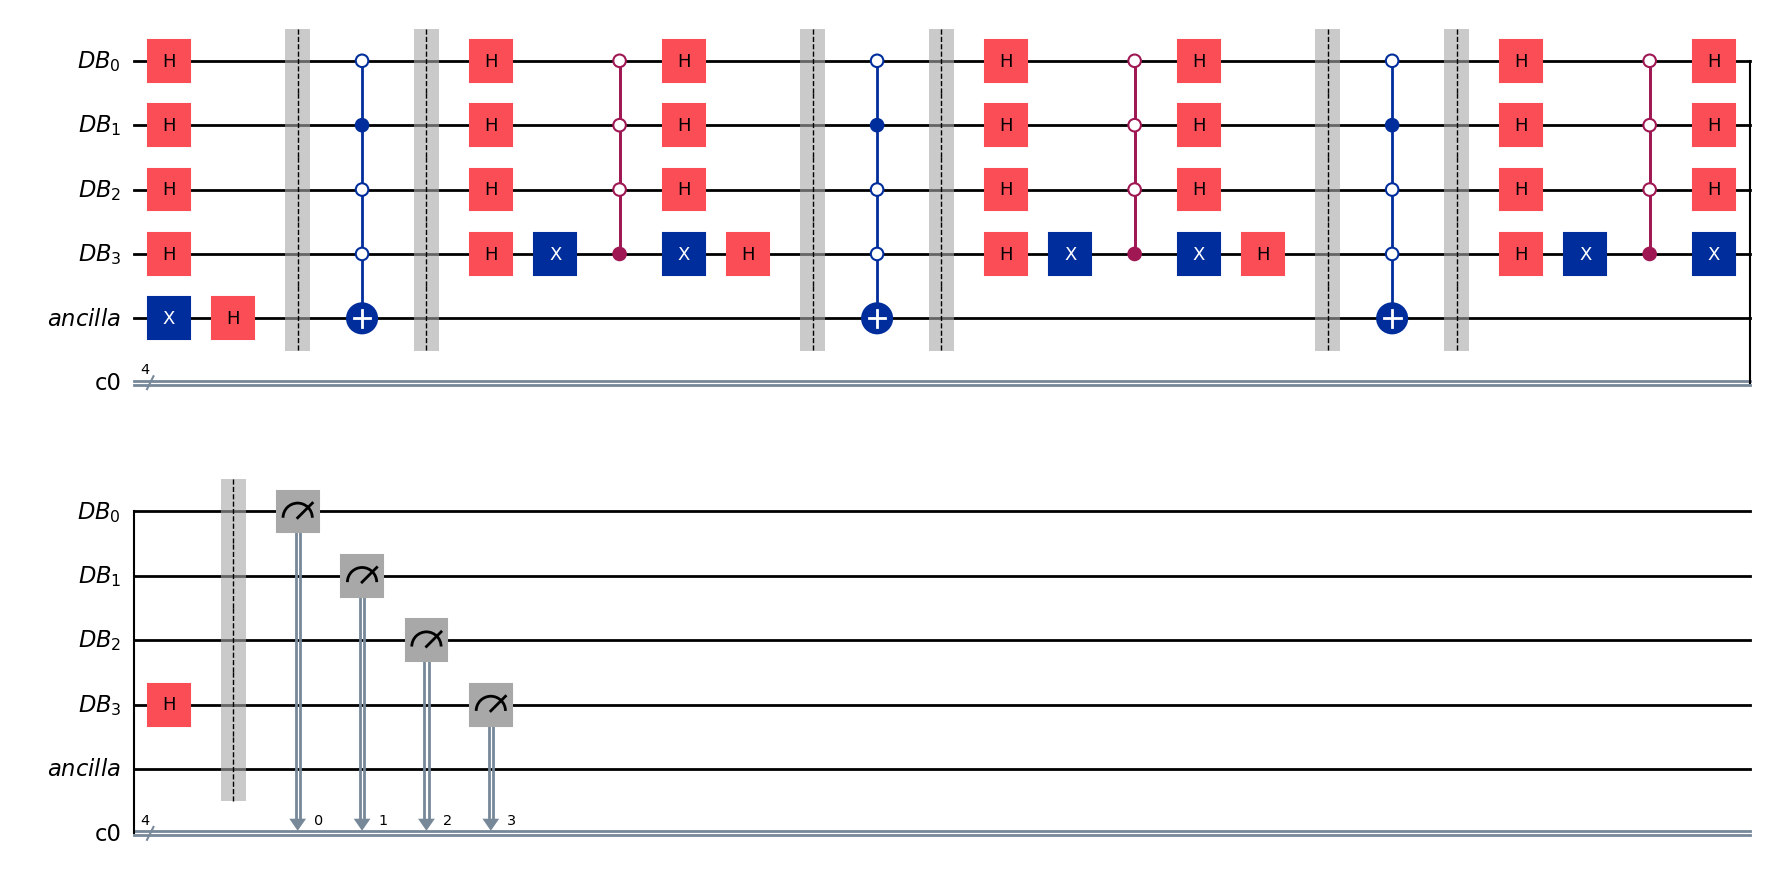

In [8]:
qc.draw(output="mpl")

Alteramos apenas a variável "solution" , pois agora queremos que a solução seja o estado que estamos a tentar encontra ( **|0010⟩**) e alteramos o numero de qubits pois agora temos 4.

O número ótimo de iterações é dado pelo arredondamento para inteiro de$$\frac{\pi}{4} \cdot \sqrt{\frac{N}{k}}$$

Em que N é o numero de elementos e k o número de soluções.

Logo

In [9]:
print("O número ótimo de iterações de Grover é "+ str(iterations))

O número ótimo de iterações de Grover é 3


A probabilidade de encontramos o estado **|0010⟩** através do algoritmo de Grover, tem de ser aproximadamente 1 se o número ótimo de iterações estiver correto.

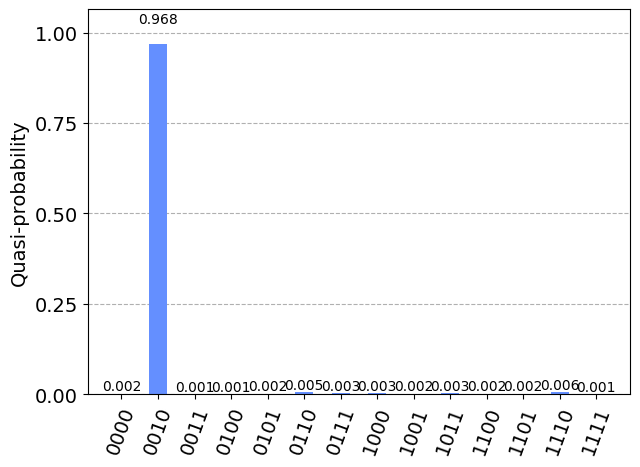

In [10]:
counts = execute_circuit(qc, shots=1024, binary=True, mode="sampler")
plot_distribution(counts)

Como podemos ver obtive aproximadamente 1 de probabilidade para o estado **|0010⟩**, logo o número ótimo de iterações está correto e obtive o esperado.

### b) 
O que mudaria caso quisesse encontrar um dos seguintes elementos **{0000,0101,1011,1110}**? Comente sobre os resultados experimentais obtidos.

## Resposta:

Temos de alterar a variável solution para um array com os elementos do set **{0000,0101,1011,1110}** , o k da formula do número ótimo de iterações dada previamente é agora o tamanho deste array , ou seja 4 e por fim agora temos de acrescentar um ciclo dentro do ciclo sobre as das iterações que percorre este array solution compondo os oracles.

Usando este raciocínio obtemos o seguinte código:

In [11]:
qr=QuantumRegister(4,"DB")
ancilla=QuantumRegister(1,"ancilla")
cr=ClassicalRegister(4)
qc =QuantumCircuit(qr,ancilla,cr)
elements = 16 # N , 2^4

qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)

qc.barrier()

solution = ["0000", "0101", "1011", "1110"]

iterations = int(np.floor(np.pi/4 * np.sqrt(elements/len(solution))))

for j in range(iterations):
    for res in solution:
        qc = qc.compose(oracle(qr,ancilla,res))
    qc = qc.compose(diffusion_operator(qr, ancilla, 4))

qc.measure(qr,cr)
print()

Que é representado pelo seguinte circuito:

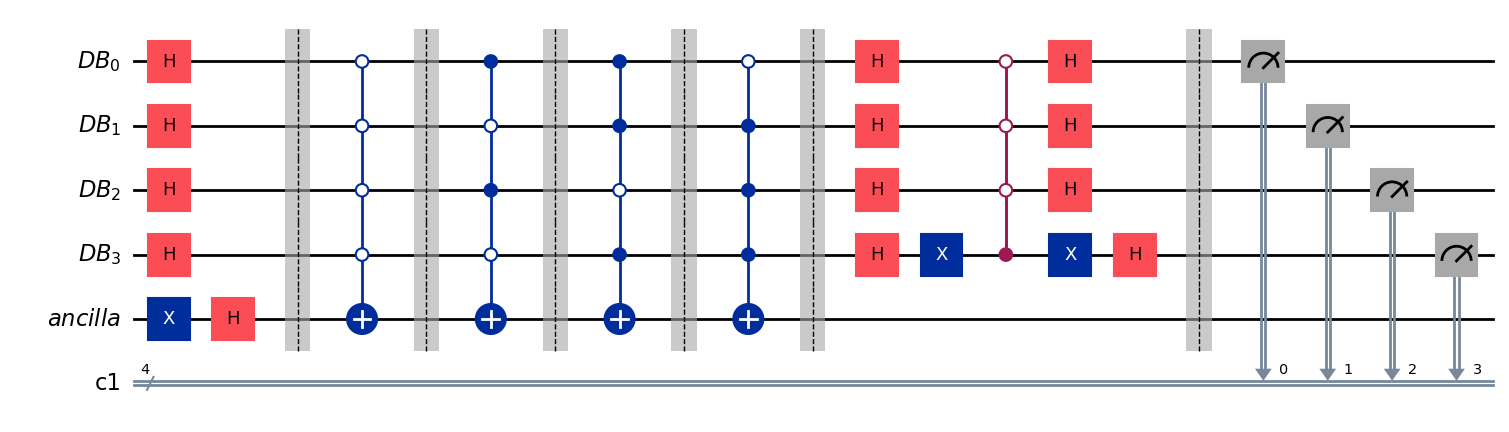

In [12]:
qc.draw(output="mpl")

Agora a probabilidade será distribuída sobre estes 4 elementos e temos então o seguinte grafico:

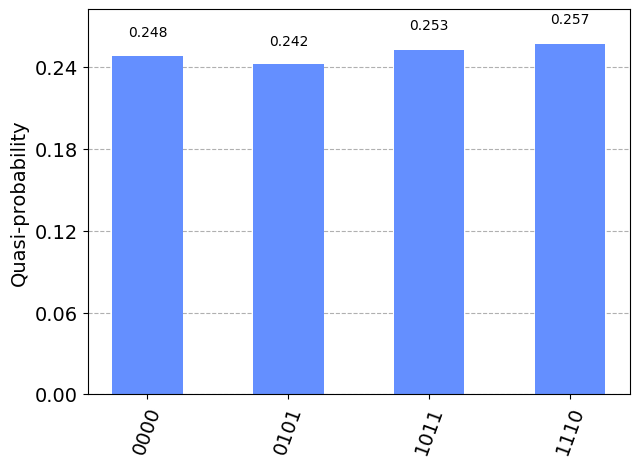

In [13]:
counts = execute_circuit(qc, shots=1024, binary=True, mode="sampler")
plot_distribution(counts)

### c) 
Considere o oráculo representado pelo seguinte circuito:

<p align="center">
  <img width="200" height="200" src="images/enunciadoexc2c.png">
</p>

Que elemento identifica o oráculo? Comente sobre os resultados expectáveis do algoritmo de Grover e os resultados experimentais obtidos.

## Resposta:

O oráculo representado por aquele circuito é um gate cnot com o ultimo bit (bit mais á esquerda) como ponto de controlo, logo são todos os elementos do formato $1xxx$ tal que $ x \in {\{0,1\}} $.

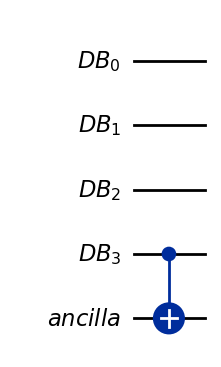

In [14]:
def oracle(qr, ancilla):
    
    qc = QuantumCircuit(qr,ancilla)
    qc.cx(qr[-1], ancilla) # Aplicar gate Cx ao bit mais significativo

    return qc

qr = QuantumRegister(4,"DB")
ancilla = QuantumRegister(1,"ancilla")
qc = oracle(qr,ancilla)
qc.draw(output="mpl")

Aplicamos este oráculo ao grover e obtemos o seguinte:

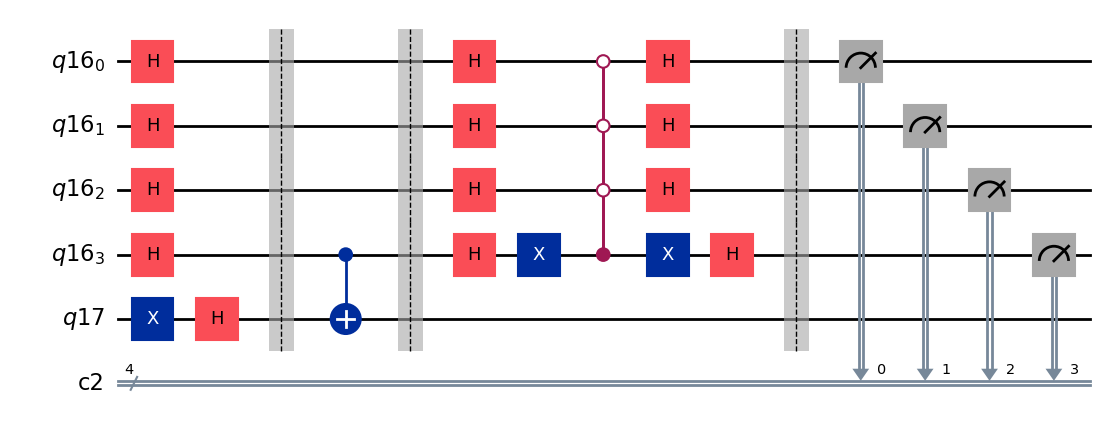

In [15]:
def oracle(qr, ancilla):
    
    qc = QuantumCircuit(qr,ancilla)
    qc.cx(qr[-1], ancilla) # Aplicar gate Cx ao bit mais significativo

    qc.barrier()
    return qc

qr=QuantumRegister(4)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(4)
qc =QuantumCircuit(qr,ancilla,cr)

qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)
qc.barrier()
elements= 16

iterations = int(np.floor(np.pi/4 * np.sqrt(elements/(elements/2))))

for j in range(iterations):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla,4))

qc.measure(qr,cr)
qc.draw(output="mpl")

Metade dos elementos terá 1 como o bit mais á esquerda logo o esperado seria a probabilidade ser distribuída entre estes, assim como no anterior com aqueles 4 elementos.

Iremos então verificar através do gráfico:

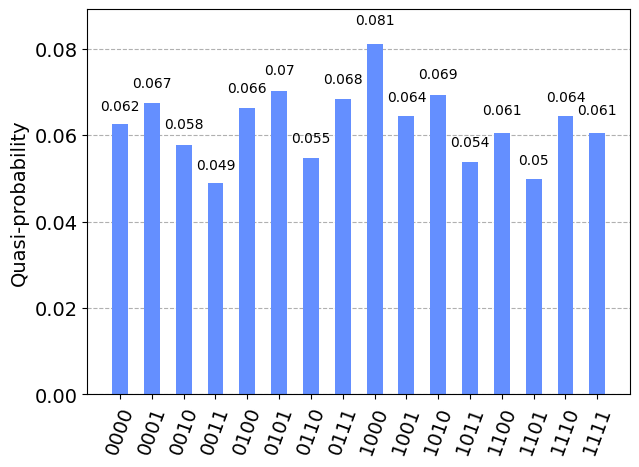

In [16]:
counts = execute_circuit(qc, shots=1024, binary=True, mode="sampler")
plot_distribution(counts)

Todos os elementos tiveram uma probabilidade de, aproximadamente, 0, o que mostra que o algoritmo de Grover não tem a capacidade de encontrar elementos quando a quantidade destes são a metade do total.

O que faz sentido porque o número de iterações será sempre aproximadamente 1 ($\frac{\pi}{4} \cdot \sqrt{\frac{N}{\frac{N}{2}}}$) logo não terá muita capacidade de encontrar os elementos.